## Data Reduction of MQ-SCExAO Lab Spectrograph

### 7 cores single mode fiber input, oriented in rotation for maximum seperation in cross dispersion direction

#### Setup Notes

Using a ZWO ASI183MM CMOS camera as the detector


* Sensor type	CMOS
* Sensor specification	 1/3″ CMOS
* Pixel Size: 2.4µm
* Bit rate: 12bit output (12bit ADC)

The setups:

Using the inner 7 cores of a 19 core Single mode Multicore Fiber
laser cut brass aperture inserted between the ferrule and the FC/PC connector are masking the outer fiber

other end of the MCF has 3D nano printed microlenses and is couple to SCExAO

Spectrograph has an R4 grating, whihc is fed from a reimaging fiber input and collimated by a 200 mm ITL lens

cross dispersion is done by a 200 line/mm grating, some significant gamma angle

camera lens is another 200 mm TTL lens

Setup is non enclosed

### import the necessary packages

In [1029]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks
from scipy.signal import medfilt

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches

import ccdproc
from astropy.nddata import CCDData
import astropy.units as u

import os
import glob

### Function definitions

### Set the pixel size for your detector
The ZWO ASI183MM camera 

In [1030]:
pixelsize=2.4

### Set up data store directories

In [1031]:
datastore_path="d:/cloudstor/datastore/SCExAO-MCF/"
proc_dir="processed/"
run_dir="16-10-2019/"
run_dir2="18-10-2019/"

### Collect filenames

In [1032]:
#bias_files=["super-k-0001bias.fit","super-k-0002bias.fit","super-k-0003bias.fit"]

bias_files=glob.glob(os.path.join(datastore_path,run_dir,"super*bias*"))

print(bias_files)

#dark_files=["gamma-dark-480.fit","gamma-dark-480-2.fit"]

dark_files=glob.glob(os.path.join(datastore_path,run_dir,"*dark-480*"))

print(dark_files)


#flat_files=[datastore_path + run_dir + "super-k-flat-10.fit"]
flat_files=[datastore_path + run_dir2 + "halogen.fit"]


print(flat_files)

science_files=[datastore_path + run_dir + "gamma_1.fit"]

print(science_files)

cal_files=glob.glob(os.path.join(datastore_path,run_dir,"*xe-300*"))

print(cal_files)


['d:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0001bias.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0002bias.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0003bias.fit']
['d:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480-2.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480.fit']
['d:/cloudstor/datastore/SCExAO-MCF/18-10-2019/halogen.fit']
['d:/cloudstor/datastore/SCExAO-MCF/16-10-2019/gamma_1.fit']
['d:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-1.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-2.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-3.fit', 'd:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300.fit']


## I. Prepare Images

### Create Master bias

In [1033]:
mb_filename=os.path.join(datastore_path,proc_dir,"masterbias.fit")

if os.path.exists(mb_filename) == False:
    mb_ccd = ccdproc.combine(bias_files,mb_filename,method="median",unit="adu")
else:
    mb_ccd = CCDData.read(mb_filename)  
    

print(np.mean(mb_ccd))
print(np.min(mb_ccd))
print(np.max(mb_ccd))


712.7581199874419
420.0
1004.0


### Create Master dark and bias correct it

In [1034]:
dk_filename=os.path.join(datastore_path,proc_dir,"masterdark.fit")
dark_exp = 300.0*u.second
flat_exp = 300.0*u.second
sci_exp = 480.0*u.second
cal_exp = 300.0*u.second


if os.path.exists(dk_filename) == False:
    darkcombined = ccdproc.combine(dark_files,method="median",unit="adu")
    dk_ccd = ccdproc.subtract_bias(darkcombined, mb_ccd)
    dk_ccd.write(dk_filename)
else:
    dk_ccd = CCDData.read(dk_filename)

darkpixel = (np.mean(dk_ccd)).round(0)
print(darkpixel)
print(np.min(dk_ccd))
print(np.max(dk_ccd))


38.0
-336.0
16428.0


### Preview the halogen flat, 300s exposure

The first set of complete cores is order 1 (at the bottom of the frame). Order 2 is the next one up the frame and so forth.

The left side of the from is the bottom of the chip, closest to the bench.

Given that the cross disperser is a grating, increasing order seperation occurs as the top of frame is reached, where the wavelengths are longer. 

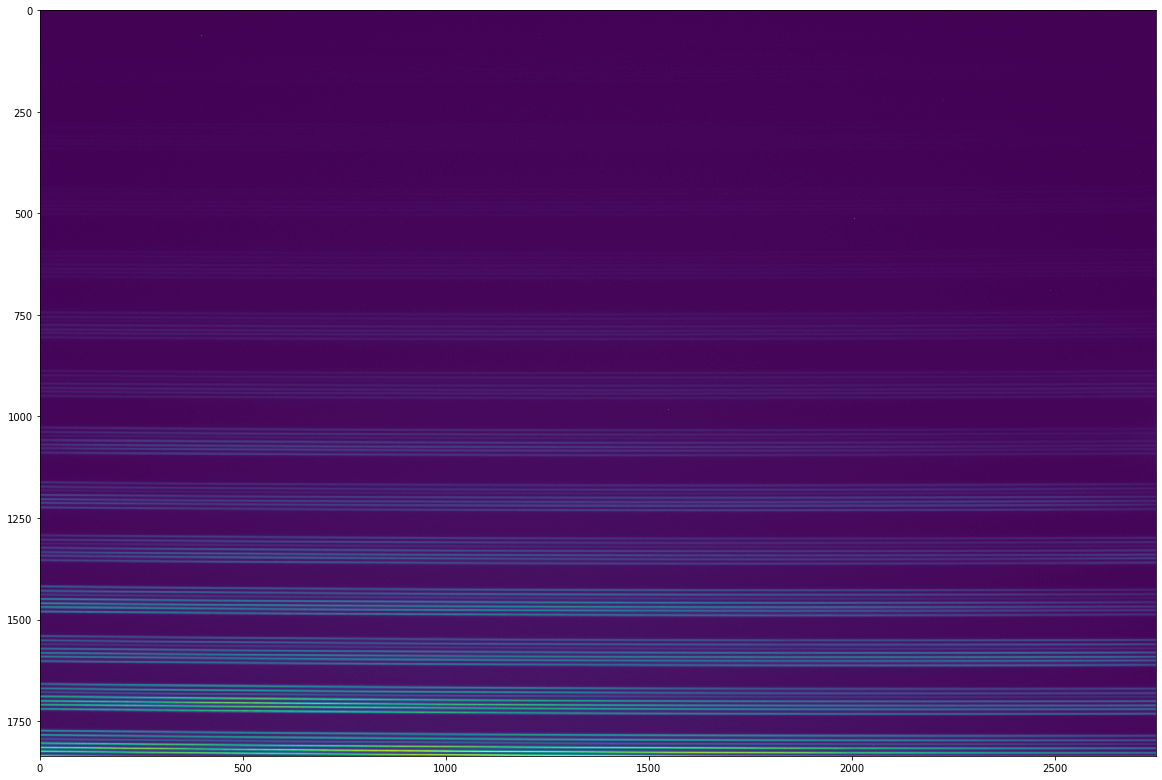

In [1035]:
flat_ccd = CCDData.read(flat_files[0],unit="adu")

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(flat_ccd,origin='upper',cmap='viridis')

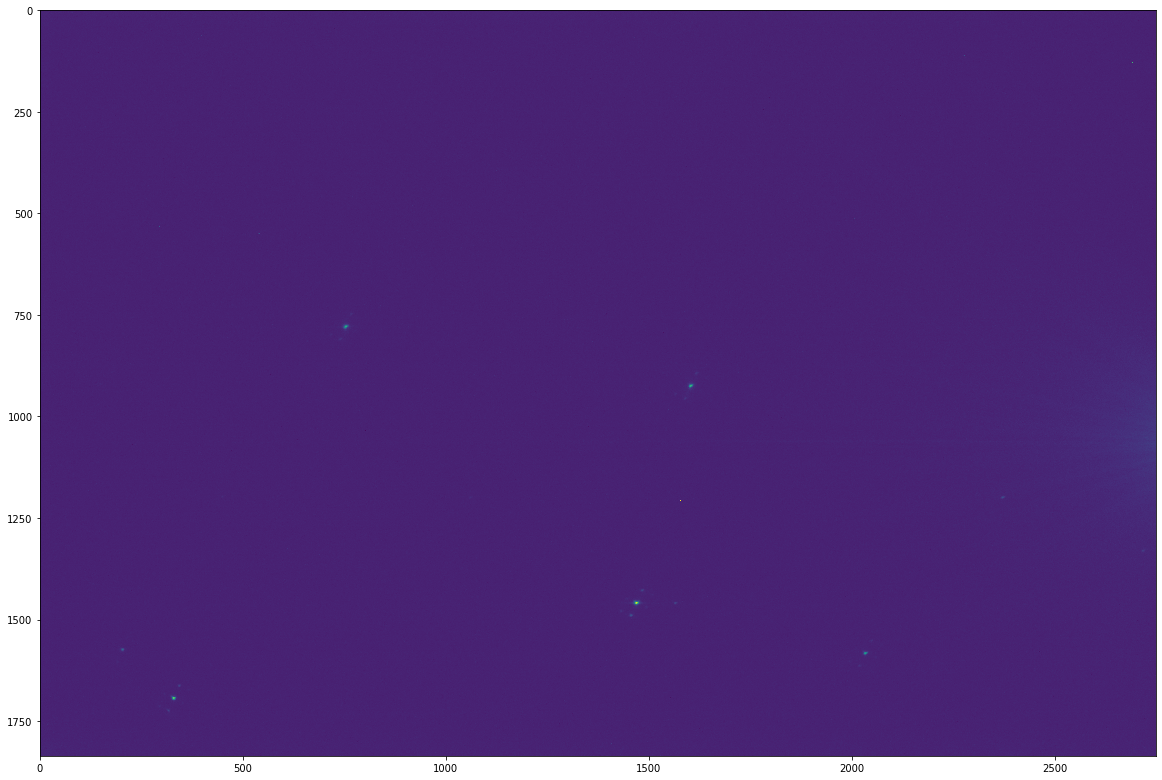

In [1036]:
cal_ccd = CCDData.read(cal_files[0],unit="adu")

cal_ccd3 = np.cbrt(cal_ccd)/(np.max(cal_ccd))
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(cal_ccd3,origin='upper',cmap='viridis')

fig.savefig('cal-2dspectra.png')

### Preview the science exposure

In [1037]:

sci_ccd = CCDData.read(science_files[0], unit="adu")

#Exposure is binned 2, 480 sec of Gamma gem, taken through SCExAO, 3dprinted MCF at highest observability

In [1038]:
sci_ccd.shape

detector_h=1836
detector_w=2748

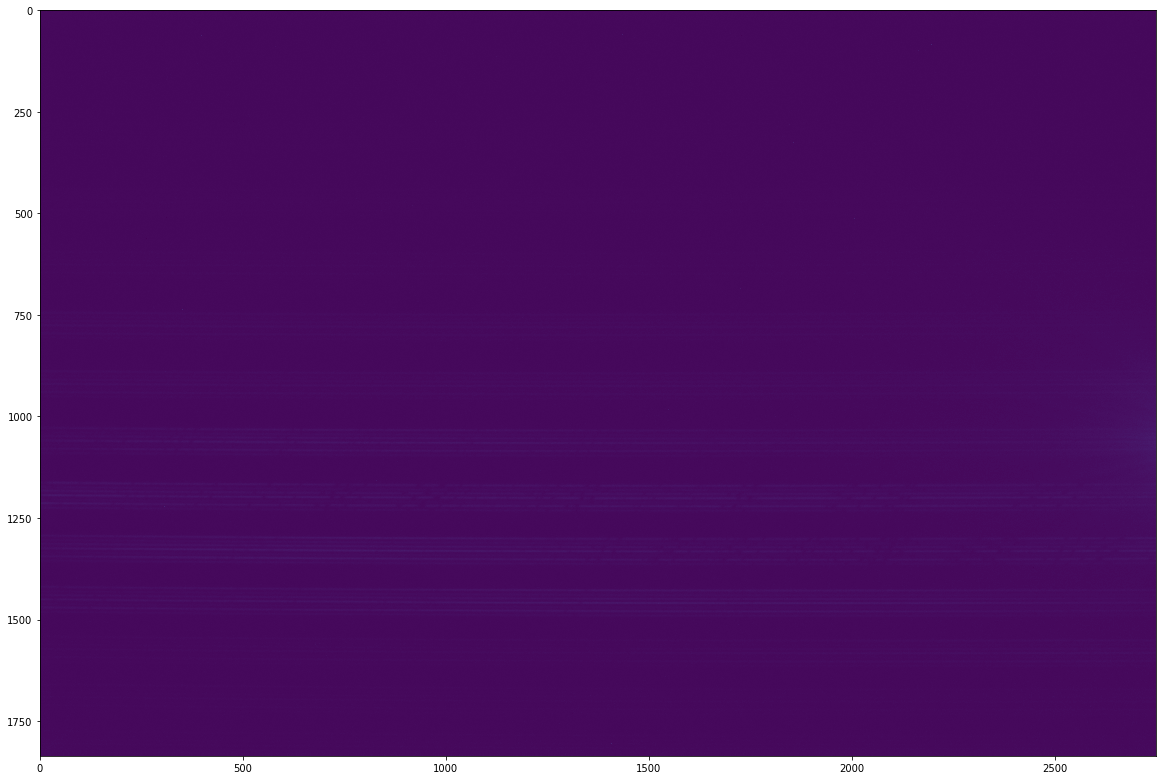

In [1039]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(sci_ccd,origin='upper',cmap='viridis')

### Subtract Darks and Bias from flat exposure

Text(0.5, 1.0, 'Orders - halogen flat')

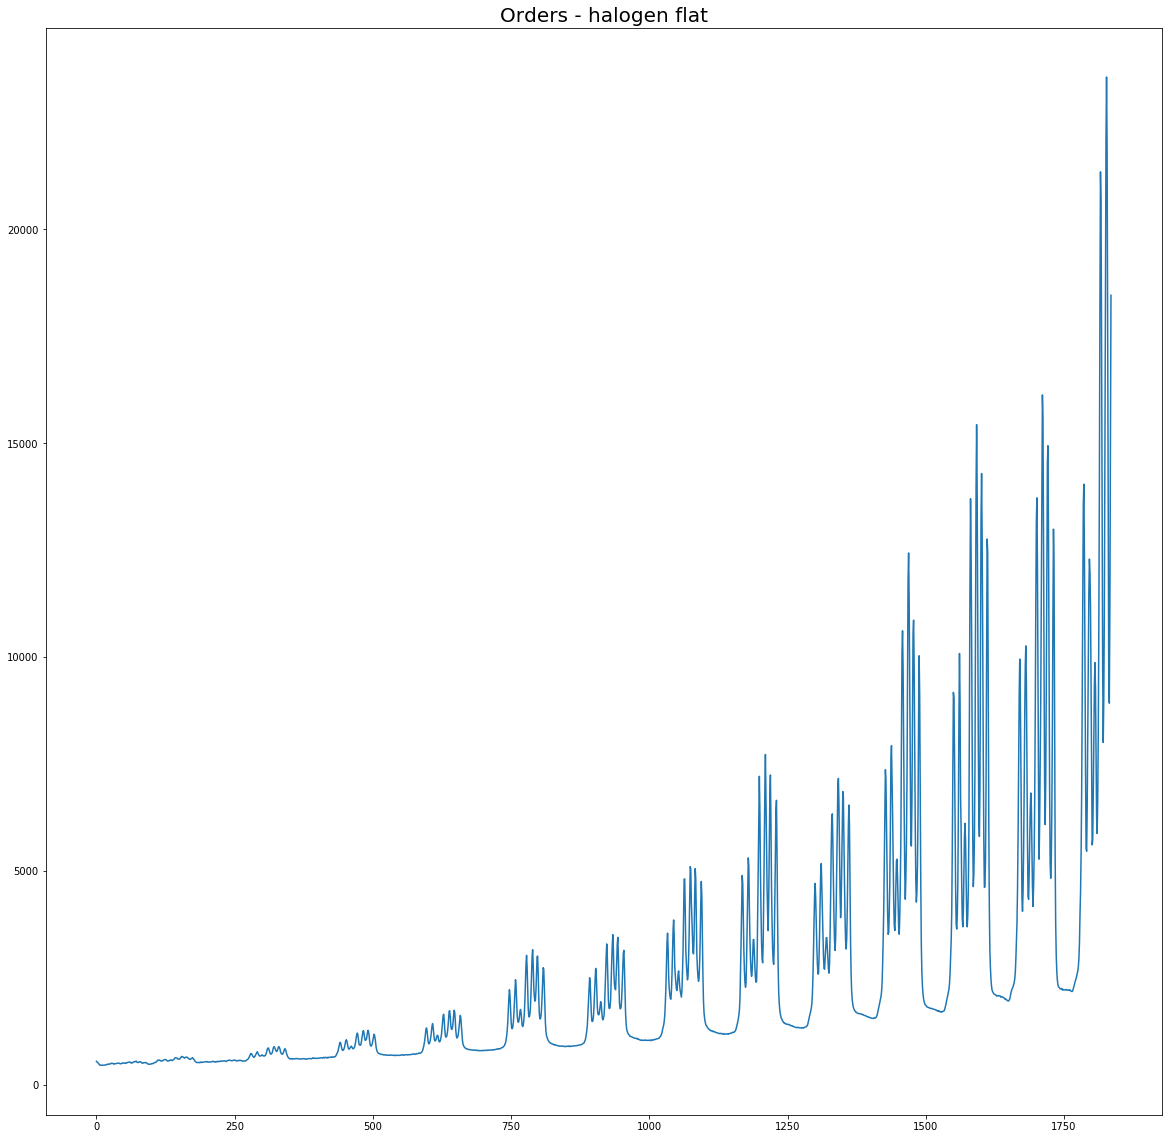

In [1040]:


procflat = ccdproc.subtract_bias(flat_ccd, mb_ccd)
procflat = ccdproc.subtract_dark(procflat,dk_ccd, data_exposure = flat_exp, dark_exposure = dark_exp, scale = True)

#median filter
#procflat = ccdproc.median_filter(procflat,size=2)

#instead of median filter, do a swap of the negative values with the dark pixel median
procflat.data[procflat.data < 0] = darkpixel

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
plt.title("Orders - halogen flat",fontsize=20)

Text(0.5, 1.0, 'Blaze trace of whole frame - halogen flat')

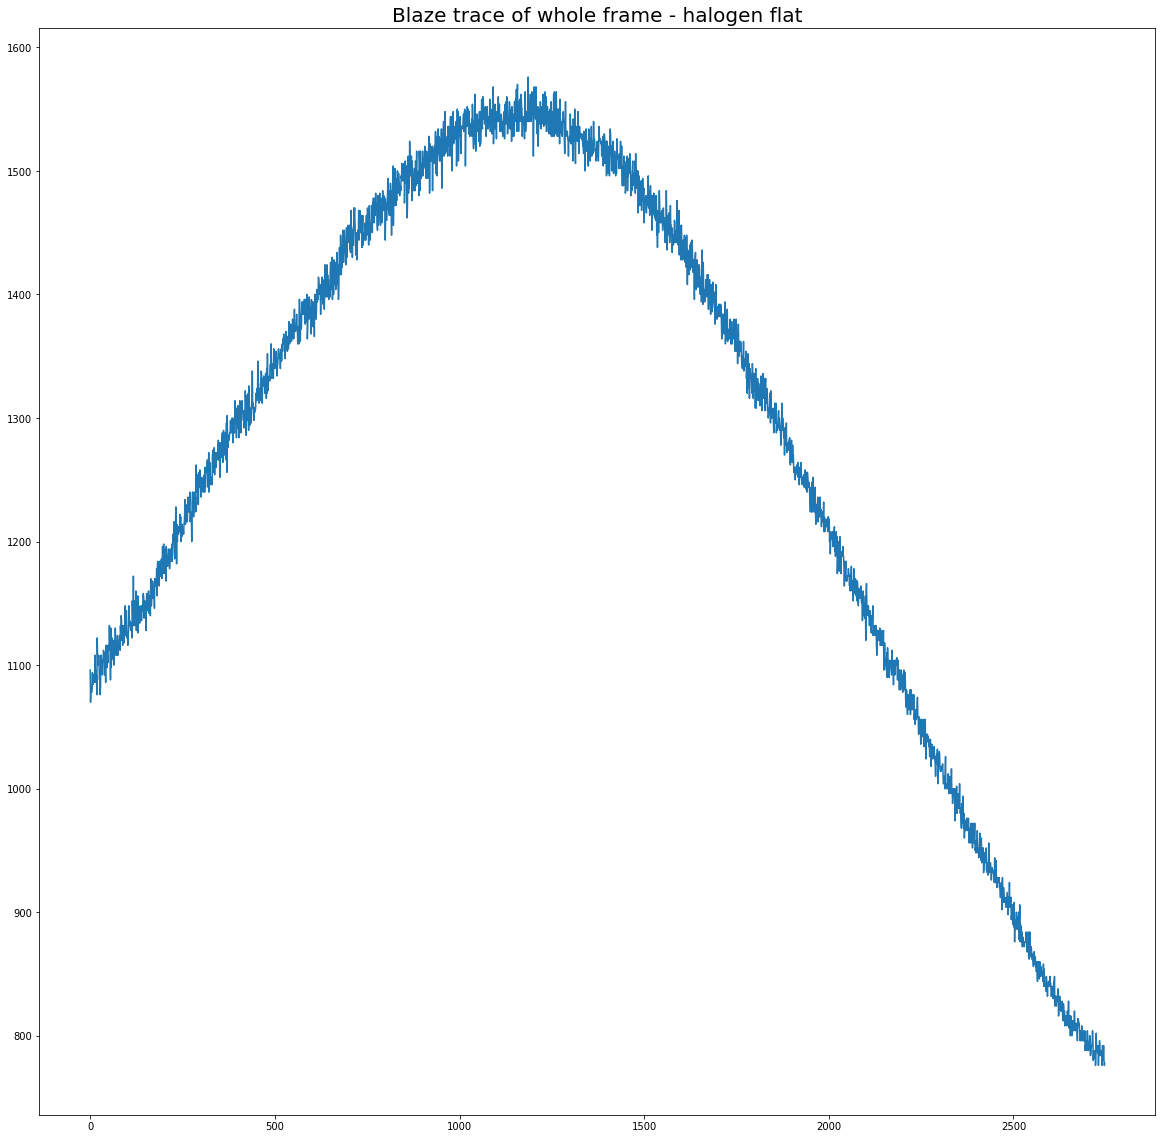

In [1041]:
plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=0))
plt.title("Blaze trace of whole frame - halogen flat",fontsize=20)

### Subtract Darks and Bias from xe exposure

In [1042]:
cal_ccd = CCDData.read(cal_files[0], unit="adu")

proccal = ccdproc.subtract_bias(cal_ccd, mb_ccd)


proccal = ccdproc.subtract_dark(proccal,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)

proccal.data[proccal.data < 0] = darkpixel

#proccal = ccdproc.median_filter(proccal,size=2)


### Subtract Darks and Bias from science exposure

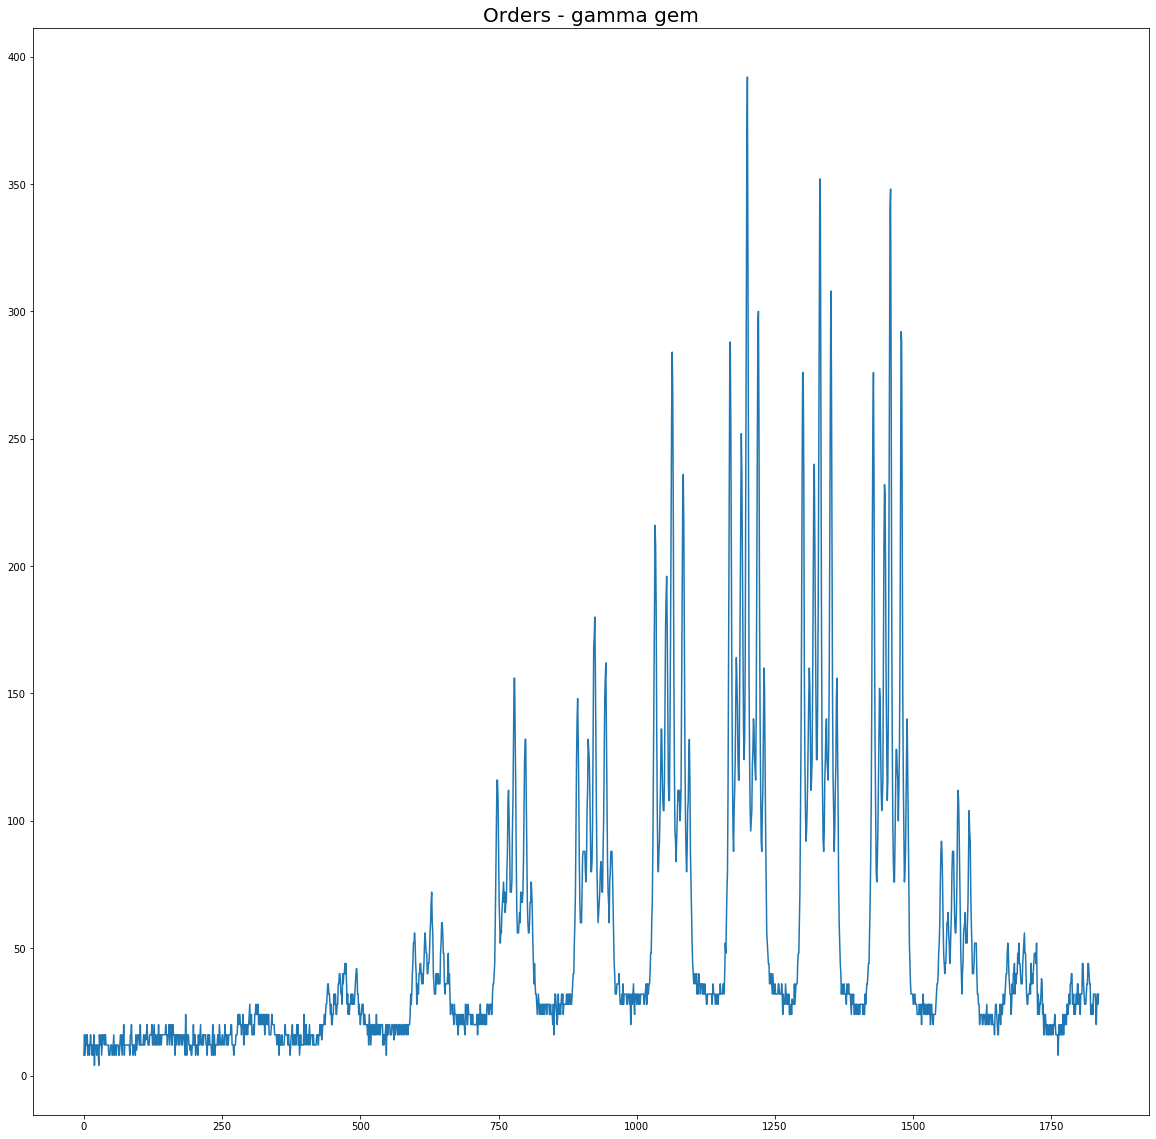

In [1043]:
procsci = ccdproc.subtract_bias(sci_ccd, mb_ccd)


procsci = ccdproc.subtract_dark(procsci,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)


plt.figure(figsize=(20, 20))
plt.plot(np.median(procsci,axis=1))
plt.title("Orders - gamma gem",fontsize=20)

procsci.data[procsci.data < 0] = darkpixel

#procsci = ccdproc.median_filter(procsci,size=2)



### Plot the processed frames

Text(0.5, 1.0, 'processed halonge flat')

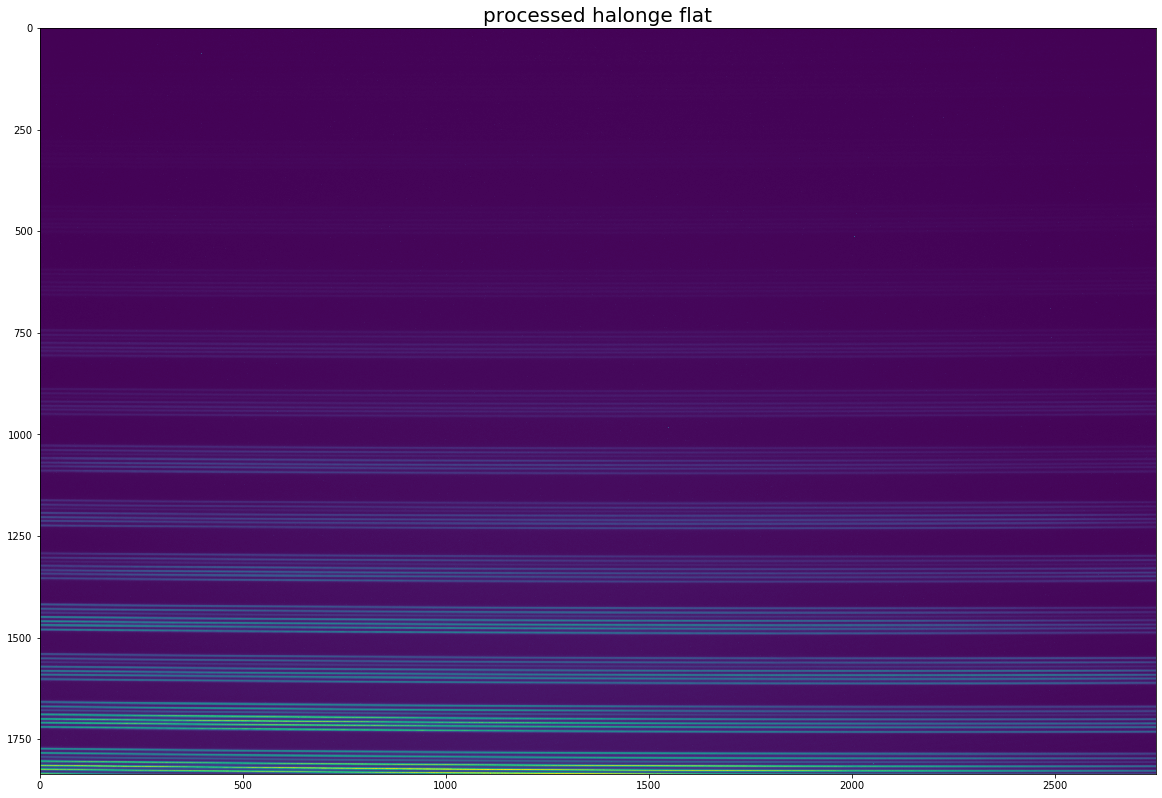

In [1044]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procflat,origin='upper',cmap='viridis')
plt.title("processed halonge flat",fontsize=20)

Text(0.5, 1.0, 'processed gamma gem')

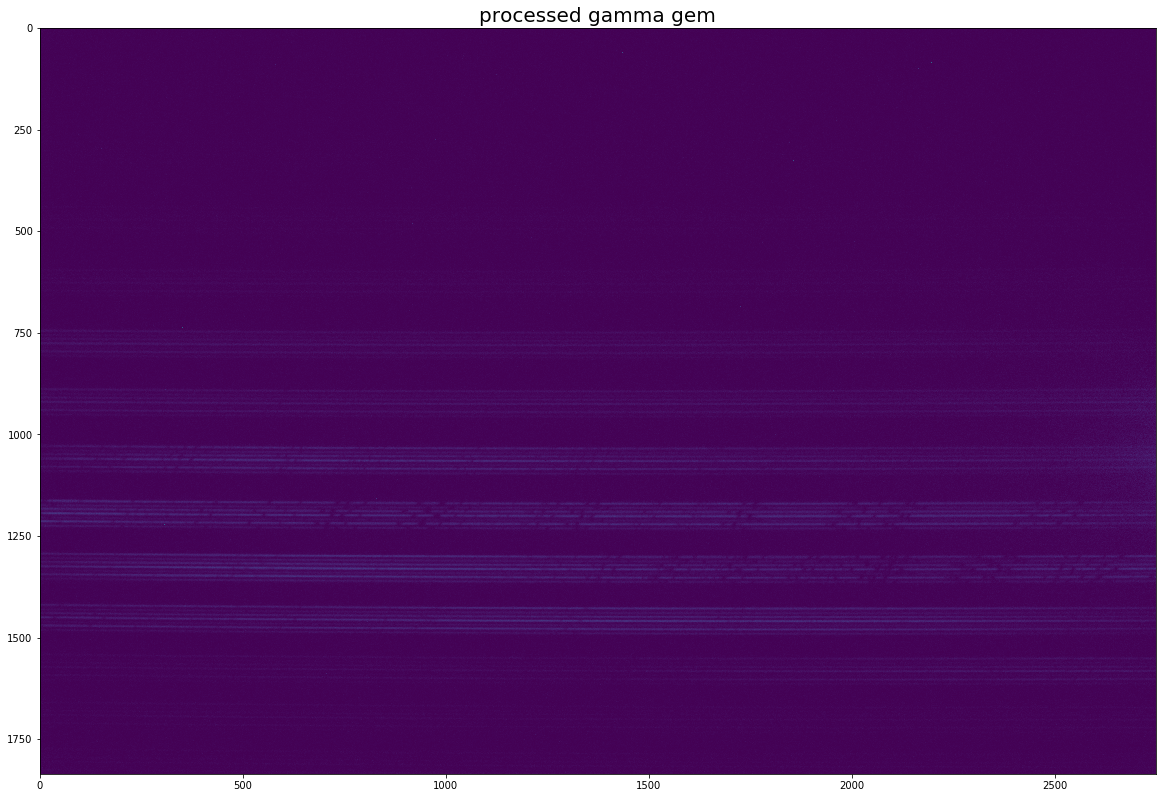

In [1045]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procsci,origin='upper',cmap='viridis')
plt.title("processed gamma gem",fontsize=20)

### II. Use the flat exposure to locate order locations

### Show the selection on the frame and mark the orders manually

count orders from right to left

Text(0.5, 1.0, 'Orders with bounds set')

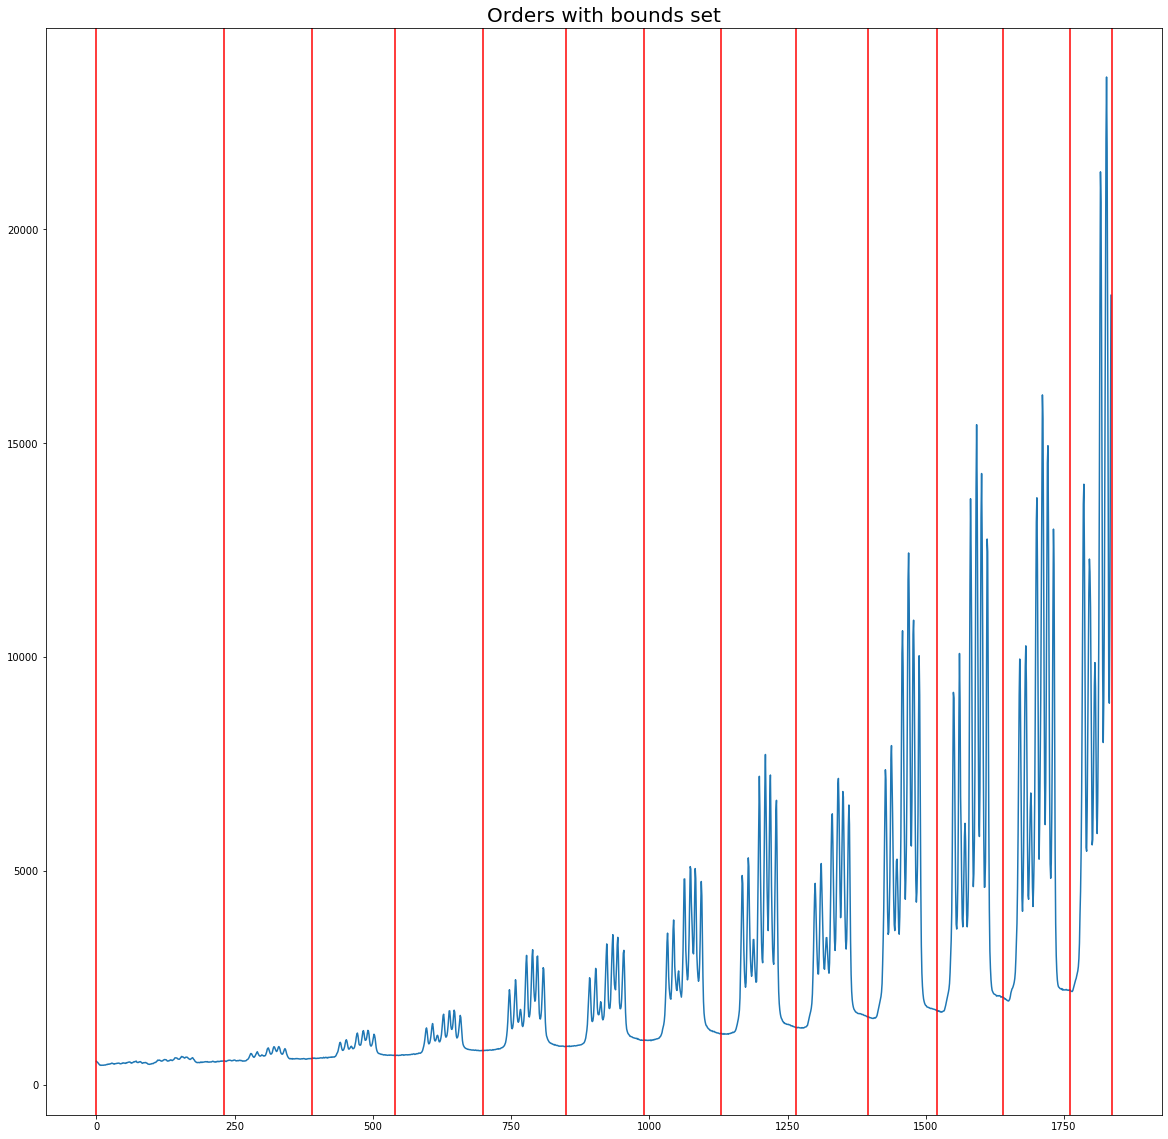

In [1046]:
flat_median = np.median(procflat,axis=1)


orders=[1836,1760,1640,1520,1395,1265,1130,990,850,700,540,390,230,0]


#order_offset=

#order 65 = orders[1]:order[0] 1836-1760
#order 64 = orders[2]:order[1] 1760-1640

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
for i in orders:
    plt.axvline(i,color='red')
plt.title("Orders with bounds set",fontsize=20)

good features in order 4 and 5 
1130,1265
1265,1395

### Crop out orders on the processed flat, cal and science exposures

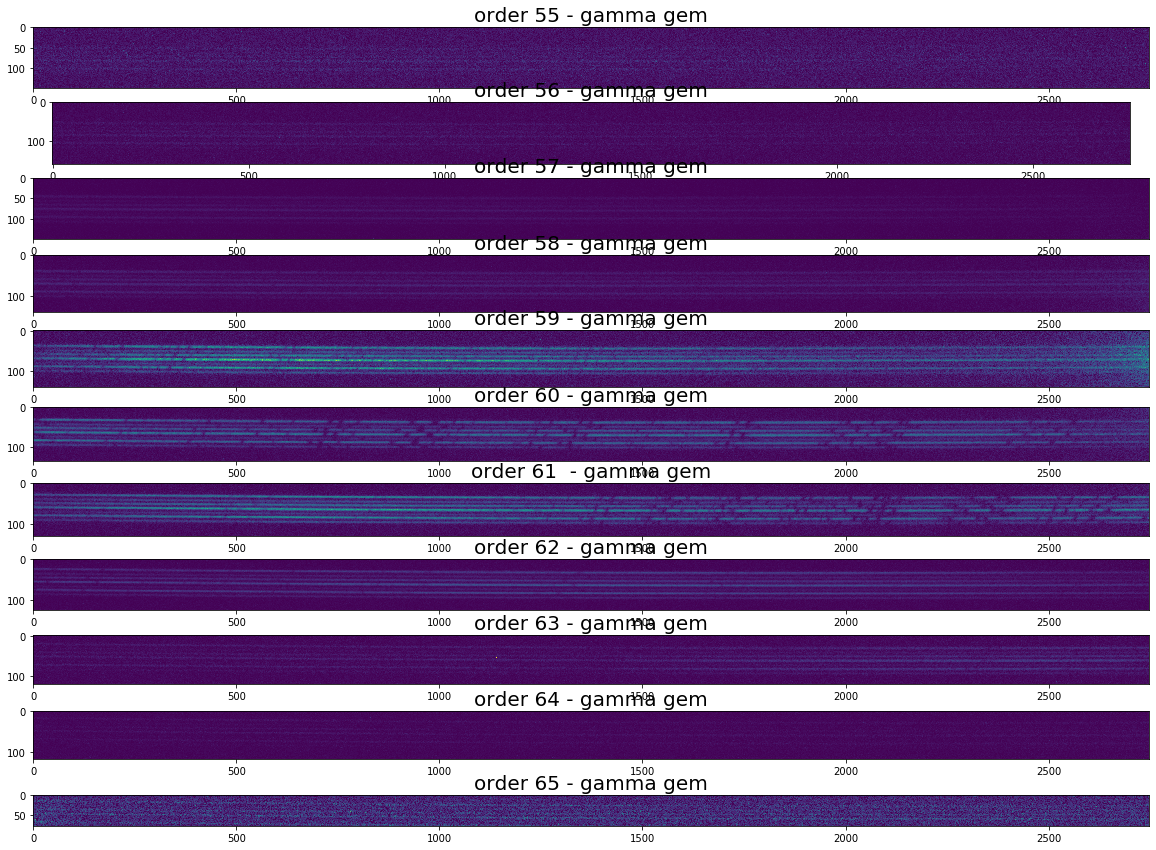

In [1047]:
orderflat53=ccdproc.trim_image(procflat[orders[13]:orders[12],:])
orderflat54=ccdproc.trim_image(procflat[orders[12]:orders[11],:])
orderflat55=ccdproc.trim_image(procflat[orders[11]:orders[10],:])
orderflat56=ccdproc.trim_image(procflat[orders[10]:orders[9],:])
orderflat57=ccdproc.trim_image(procflat[orders[9]:orders[8],:])
orderflat58=ccdproc.trim_image(procflat[orders[8]:orders[7],:])
orderflat59=ccdproc.trim_image(procflat[orders[7]:orders[6],:])
orderflat60=ccdproc.trim_image(procflat[orders[6]:orders[5],:])
orderflat61=ccdproc.trim_image(procflat[orders[5]:orders[4],:])
orderflat62=ccdproc.trim_image(procflat[orders[4]:orders[3],:])
orderflat63=ccdproc.trim_image(procflat[orders[3]:orders[2],:])
orderflat64=ccdproc.trim_image(procflat[orders[2]:orders[1],:])
orderflat65=ccdproc.trim_image(procflat[orders[1]:orders[0],:])

ordercal53=ccdproc.trim_image(proccal[orders[13]:orders[12],:])
ordercal54=ccdproc.trim_image(proccal[orders[12]:orders[11],:])
ordercal55=ccdproc.trim_image(proccal[orders[11]:orders[10],:])
ordercal56=ccdproc.trim_image(proccal[orders[10]:orders[9],:])
ordercal57=ccdproc.trim_image(proccal[orders[9]:orders[8],:])
ordercal58=ccdproc.trim_image(proccal[orders[8]:orders[7],:])
ordercal59=ccdproc.trim_image(proccal[orders[7]:orders[6],:])
ordercal60=ccdproc.trim_image(proccal[orders[6]:orders[5],:])
ordercal61=ccdproc.trim_image(proccal[orders[5]:orders[4],:])
ordercal62=ccdproc.trim_image(proccal[orders[4]:orders[3],:])
ordercal63=ccdproc.trim_image(proccal[orders[3]:orders[2],:])
ordercal64=ccdproc.trim_image(proccal[orders[2]:orders[1],:])
ordercal65=ccdproc.trim_image(proccal[orders[1]:orders[0],:])

ordersci53=ccdproc.trim_image(procsci[orders[13]:orders[12],:])
ordersci54=ccdproc.trim_image(procsci[orders[12]:orders[11],:])
ordersci55=ccdproc.trim_image(procsci[orders[11]:orders[10],:])
ordersci56=ccdproc.trim_image(procsci[orders[10]:orders[9],:])
ordersci57=ccdproc.trim_image(procsci[orders[9]:orders[8],:])
ordersci58=ccdproc.trim_image(procsci[orders[8]:orders[7],:])
ordersci59=ccdproc.trim_image(procsci[orders[7]:orders[6],:])
ordersci60=ccdproc.trim_image(procsci[orders[6]:orders[5],:])
ordersci61=ccdproc.trim_image(procsci[orders[5]:orders[4],:])
ordersci62=ccdproc.trim_image(procsci[orders[4]:orders[3],:])
ordersci63=ccdproc.trim_image(procsci[orders[3]:orders[2],:])
ordersci64=ccdproc.trim_image(procsci[orders[2]:orders[1],:])
ordersci65=ccdproc.trim_image(procsci[orders[1]:orders[0],:])

sp=11

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax = plt.subplot(sp,1,1)
plt.title("order 55 - gamma gem",fontsize=20)
ax.imshow(ordersci55,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,2)
plt.title("order 56 - gamma gem",fontsize=20)
ax.imshow(ordersci56,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,3)
plt.title("order 57 - gamma gem",fontsize=20)
ax.imshow(ordersci57,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,4)
plt.title("order 58 - gamma gem",fontsize=20)
ax.imshow(ordersci58,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,5)
plt.title("order 59 - gamma gem",fontsize=20)
ax.imshow(ordersci59,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,6)
plt.title("order 60 - gamma gem",fontsize=20)
ax.imshow(ordersci60,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,7)
plt.title("order 61  - gamma gem",fontsize=20)
ax.imshow(ordersci61,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,8)
plt.title("order 62 - gamma gem",fontsize=20)
ax.imshow(ordersci62,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,9)
plt.title("order 63 - gamma gem",fontsize=20)
ax.imshow(ordersci63,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,10)
plt.title("order 64 - gamma gem",fontsize=20)
ax.imshow(ordersci64,origin='upper',cmap='viridis')
ax = plt.subplot(sp,1,11)
plt.title("order 65 - gamma gem",fontsize=20)
ax.imshow(ordersci65,origin='upper',cmap='viridis')

## Process Order 55

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1048]:
# manually determine bound for central core start and end pixel row
cc0 = 75
cc1 = 88
curorder=55

Text(0.5, 1.0, 'Plot of pixel column 10 1500 2300 (cross dispersion direction) of Order 55')

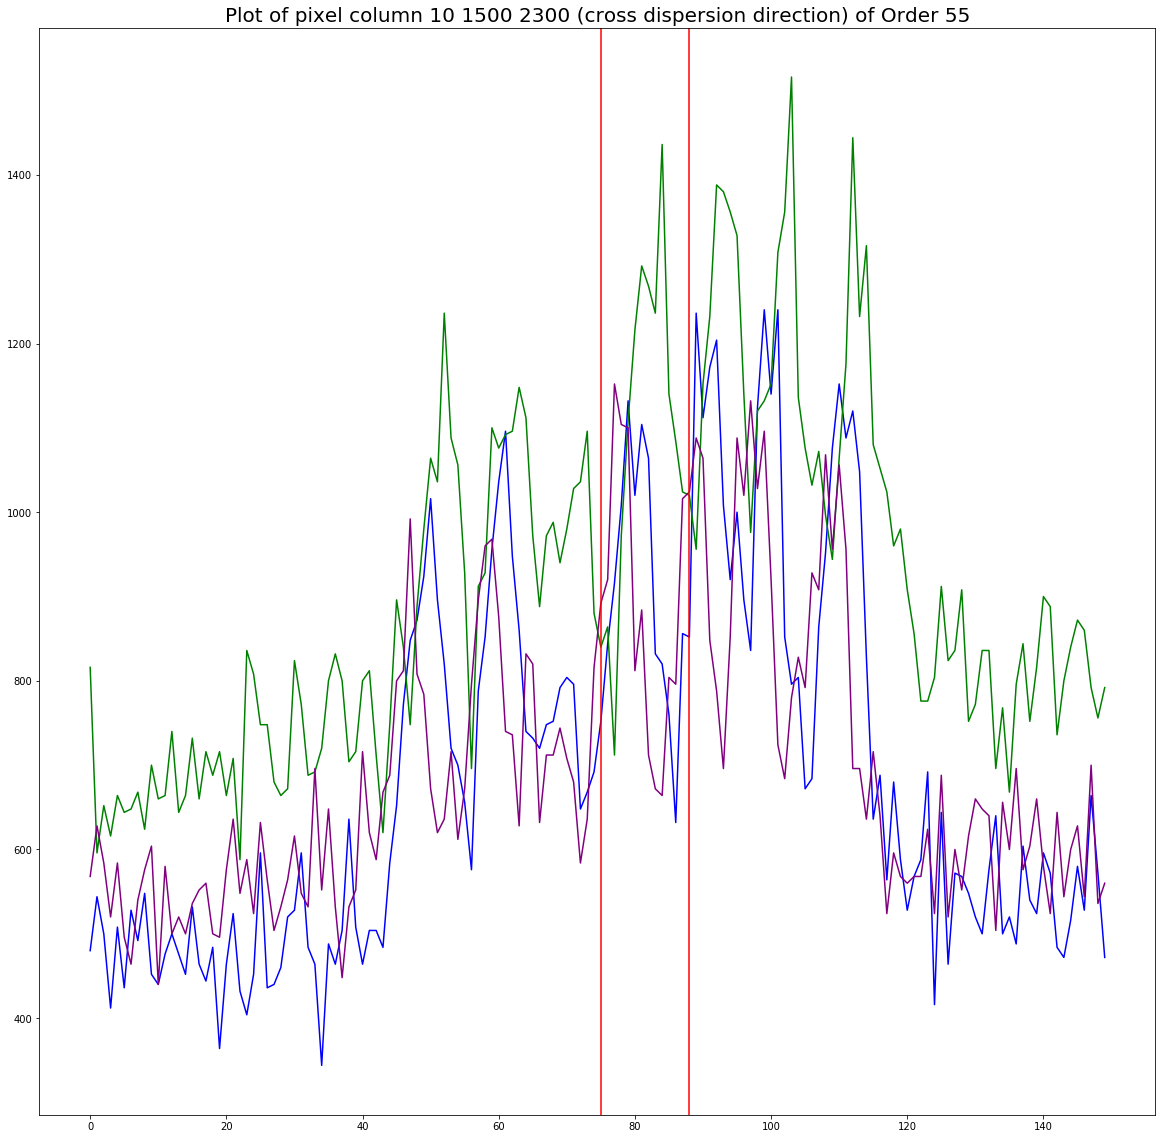

In [1049]:
whatcol1=10
whatcol2=1500
whatcol3=2300

plt.figure(figsize=(20, 20))
plt.plot(orderflat55.data[:,whatcol1],color='blue')
plt.plot(orderflat55.data[:,whatcol2],color='green')
plt.plot(orderflat55.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1050]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

detector_w = 2300

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat55.data[cc0:cc1,i], height=650)
    column_peaks.append(y[which_mcf]+cc0)
    #print(str(i) + ' ' + str(y))
    column_peaks_intensity.append(orderflat55.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


Text(0.5, 1.0, 'Order 55 center core pixel locations')

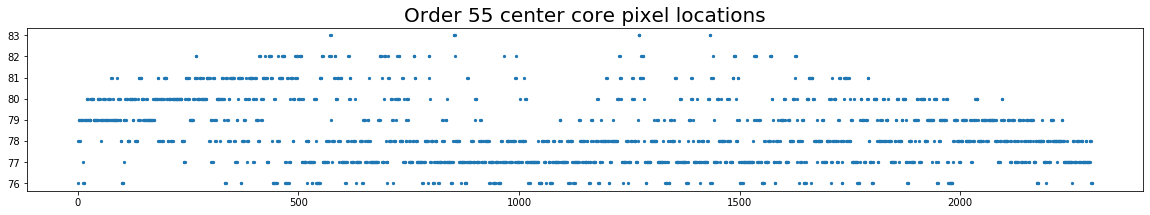

In [1051]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 55

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [1052]:
orderflat55array=orderflat55.data
ordercal55array=ordercal55.data
ordersci55array=ordersci55.data


crop_orderflat55array= []
crop_ordercal55array= []
crop_ordersci55array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat55array.append(orderflat55array[index_start:index_end,i])
    crop_ordercal55array.append(ordercal55array[index_start:index_end,i])
    crop_ordersci55array.append(ordersci55array[index_start:index_end,i])

crop_orderflat55array=np.array(crop_orderflat55array)
crop_ordercal55array=np.array(crop_ordercal55array)
crop_ordersci55array=np.array(crop_ordersci55array)

In [1053]:
#test code for ehcelle sim code

f = open('i_central_order55.txt', 'w+')
fcal = open('i_central_thxecal_order55.txt', 'w+')
fsci = open('i_central_sci_order55.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat55array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal55array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci55array[int(k),j]) + '\n')
    j=j+1

Text(0.5, 1.0, 'central core of order 55 - gamma gem, deblazed')

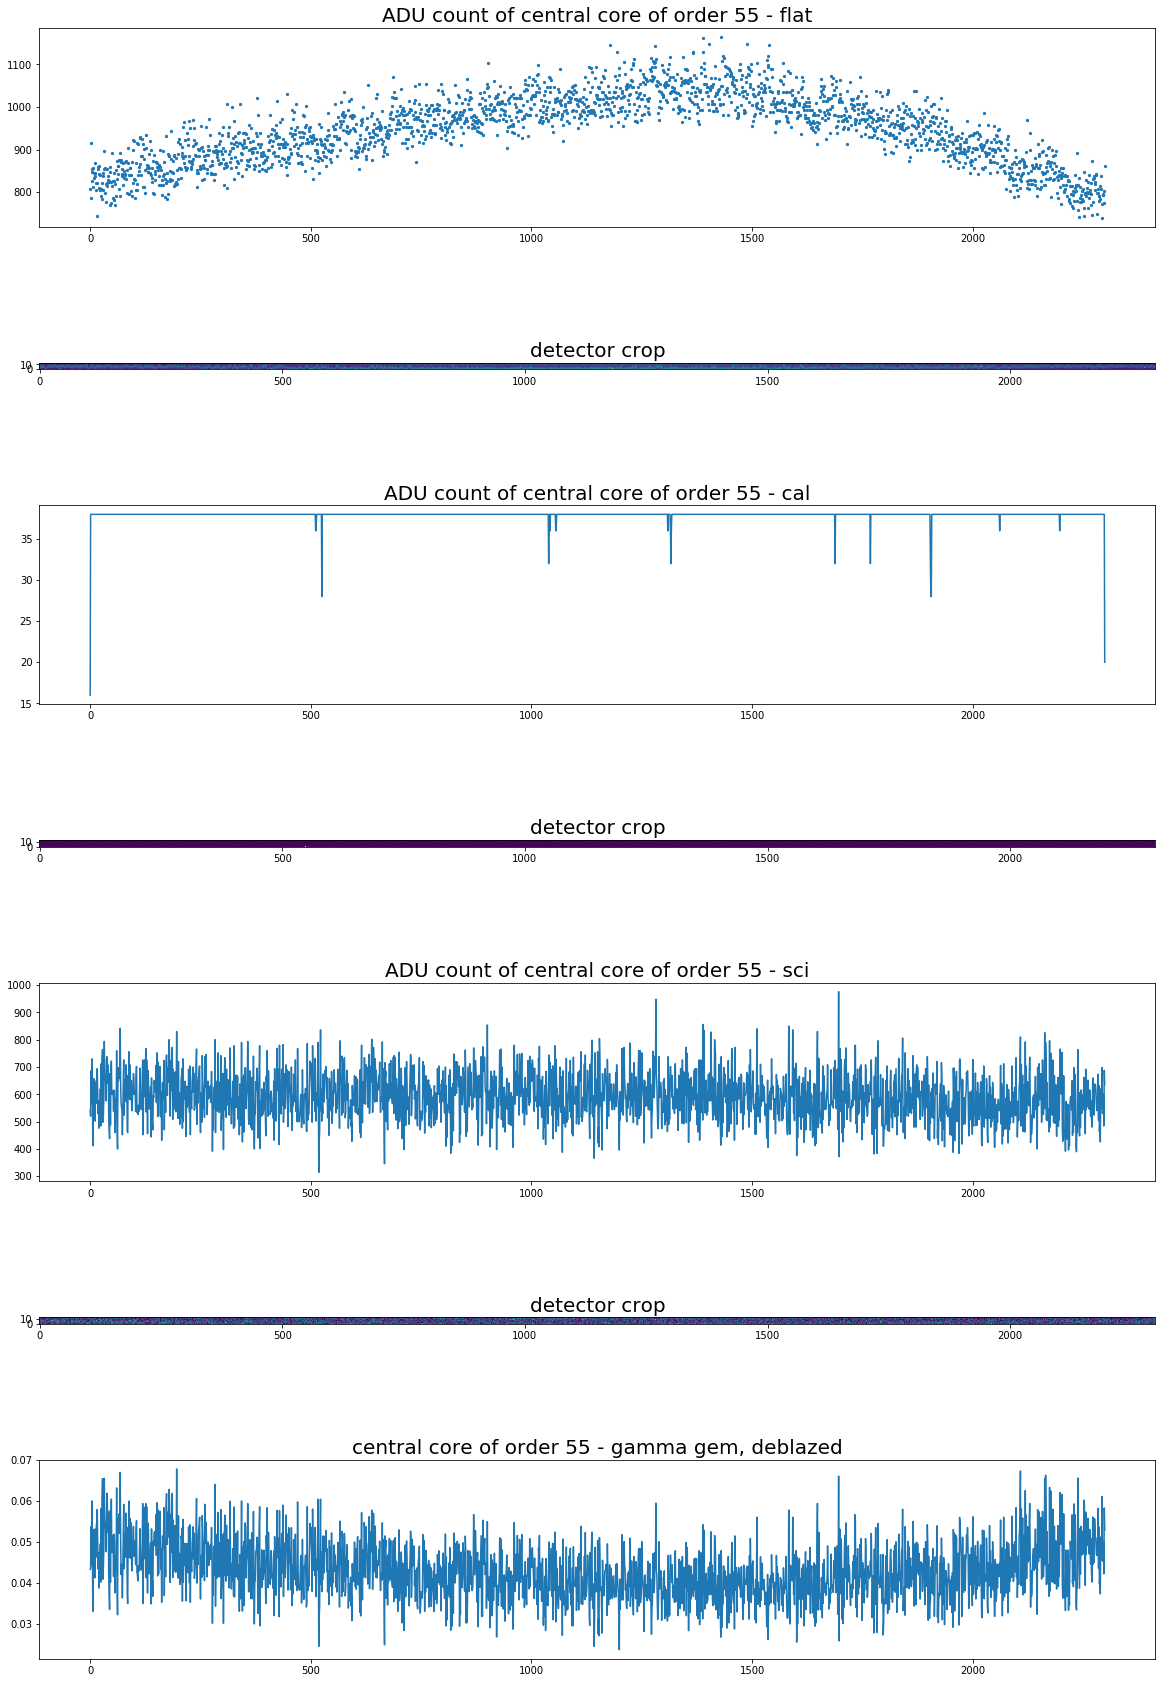

In [1054]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat55array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat55array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal55array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal55array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci55array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci55array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci55array,axis=1)/np.sum(crop_orderflat55array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


In [1055]:
detector_h=1836
detector_w=2748

## Process Order 56

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1056]:
# manually determine bound for central core start and end pixel row
cc0 = 79
cc1 = 93
curorder=56

Text(0.5, 1.0, 'Plot of pixel column 10 1500 2700 (cross dispersion direction) of Order 56')

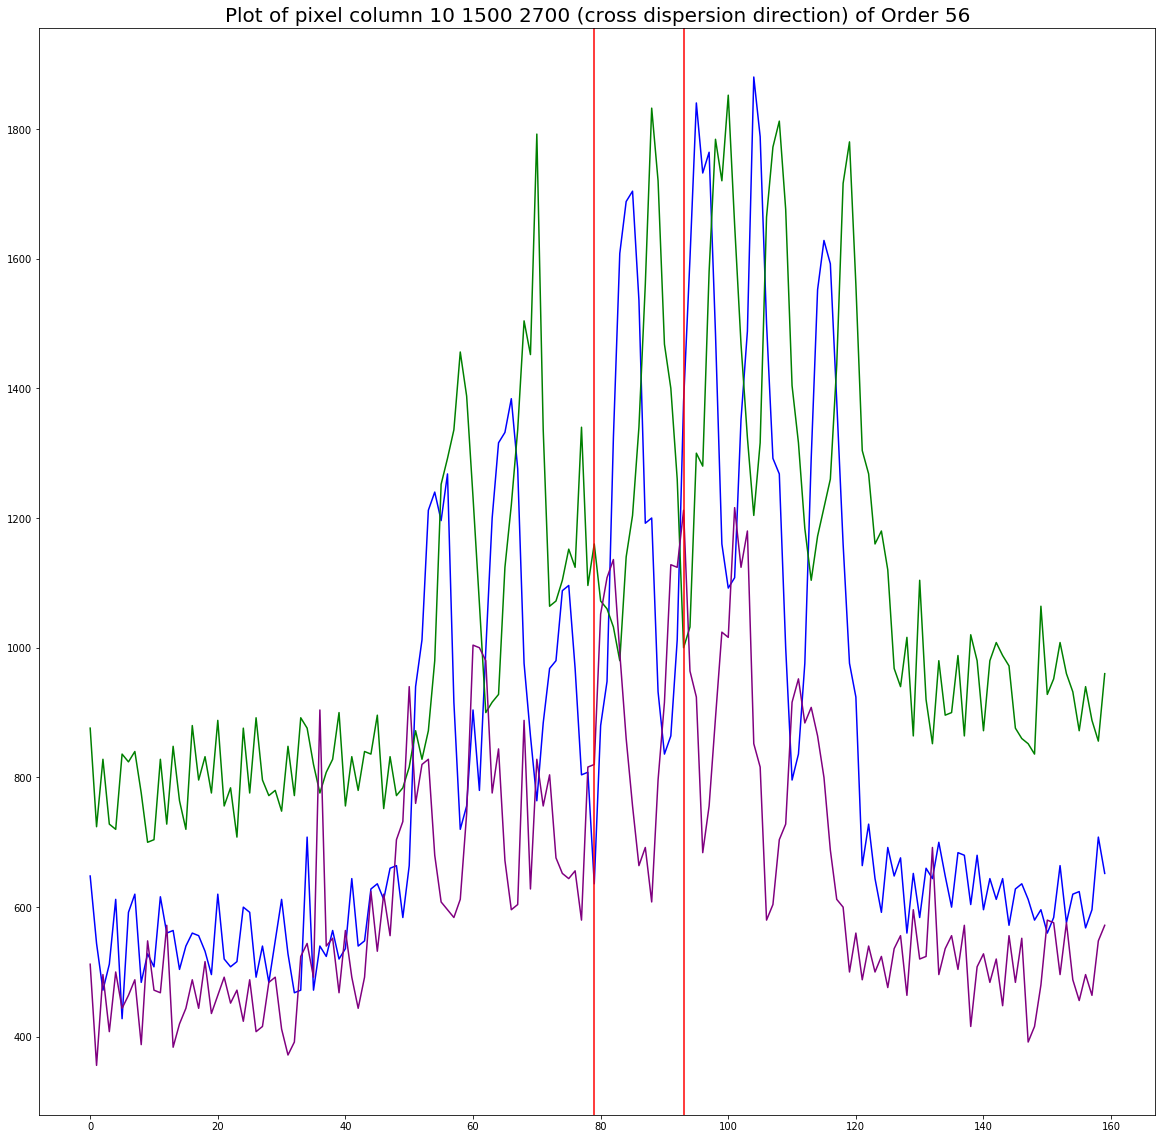

In [1057]:
whatcol1=10
whatcol2=1500
whatcol3=2700

plt.figure(figsize=(20, 20))
plt.plot(orderflat56.data[:,whatcol1],color='blue')
plt.plot(orderflat56.data[:,whatcol2],color='green')
plt.plot(orderflat56.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1058]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat56.data[cc0:cc1,i], height=1000)
    #print(str(i) + ' ' + str(y))
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat56.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


Text(0.5, 1.0, 'Order 56 center core pixel locations')

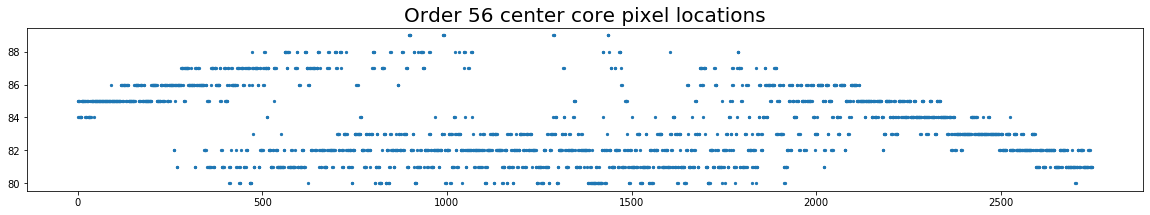

In [1059]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 56

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [1060]:
orderflat56array=orderflat56.data
ordercal56array=ordercal56.data
ordersci56array=ordersci56.data


crop_orderflat56array= []
crop_ordercal56array= []
crop_ordersci56array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat56array.append(orderflat56array[index_start:index_end,i])
    crop_ordercal56array.append(ordercal56array[index_start:index_end,i])
    crop_ordersci56array.append(ordersci56array[index_start:index_end,i])

crop_orderflat56array=np.array(crop_orderflat56array)
crop_ordercal56array=np.array(crop_ordercal56array)
crop_ordersci56array=np.array(crop_ordersci56array)

In [1061]:
#test code for ehcelle sim code

f = open('i_central_order56.txt', 'w+')
fcal = open('i_central_thxecal_order56.txt', 'w+')
fsci = open('i_central_sci_order56.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat56array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal56array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci56array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat56array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat56array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal56array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal56array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci56array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci56array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci56array,axis=1)/np.sum(crop_orderflat56array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


Text(0.5, 1.0, 'central core of order 56 - gamma gem, deblazed')

## Process Order 57

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 71
cc1 = 82
curorder=57

In [ ]:
whatcol1=10
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat57.data[:,whatcol1],color='blue')
plt.plot(orderflat57.data[:,whatcol2],color='green')
plt.plot(orderflat57.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat57.data[cc0:cc1,i], height=1350)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat57.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 57

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [ ]:
orderflat57array=orderflat57.data
ordercal57array=ordercal57.data
ordersci57array=ordersci57.data


crop_orderflat57array= []
crop_ordercal57array= []
crop_ordersci57array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat57array.append(orderflat57array[index_start:index_end,i])
    crop_ordercal57array.append(ordercal57array[index_start:index_end,i])
    crop_ordersci57array.append(ordersci57array[index_start:index_end,i])

crop_orderflat57array=np.array(crop_orderflat57array)
crop_ordercal57array=np.array(crop_ordercal57array)
crop_ordersci57array=np.array(crop_ordersci57array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order57.txt', 'w+')
fcal = open('i_central_thxecal_order57.txt', 'w+')
fsci = open('i_central_sci_order57.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat57array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal57array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci57array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat57array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat57array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal57array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal57array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci57array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci57array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci57array,axis=1)/np.sum(crop_orderflat57array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


## Process Order 58

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 65
cc1 = 78
curorder=58

In [ ]:
whatcol1=100
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat58.data[:,whatcol1],color='blue')
plt.plot(orderflat58.data[:,whatcol2],color='green')
plt.plot(orderflat58.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat58.data[cc0:cc1,i], height=2500)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat58.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 58

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [ ]:
orderflat58array=orderflat58.data
ordercal58array=ordercal58.data
ordersci58array=ordersci58.data


crop_orderflat58array= []
crop_ordercal58array= []
crop_ordersci58array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat58array.append(orderflat58array[index_start:index_end,i])
    crop_ordercal58array.append(ordercal58array[index_start:index_end,i])
    crop_ordersci58array.append(ordersci58array[index_start:index_end,i])

crop_orderflat58array=np.array(crop_orderflat58array)
crop_ordercal58array=np.array(crop_ordercal58array)
crop_ordersci58array=np.array(crop_ordersci58array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order58.txt', 'w+')
fcal = open('i_central_thxecal_order58.txt', 'w+')
fsci = open('i_central_sci_order58.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat58array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal58array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci58array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat58array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat58array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal58array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal58array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci58array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci58array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci58array,axis=1)/np.sum(crop_orderflat58array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


## Process Order 59

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 65
cc1 = 78
curorder=59

In [ ]:
whatcol1=100
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat59.data[:,whatcol1],color='blue')
plt.plot(orderflat59.data[:,whatcol2],color='green')
plt.plot(orderflat59.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat59.data[cc0:cc1,i], height=2500)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat59.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 59

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [ ]:
orderflat59array=orderflat59.data
ordercal59array=ordercal59.data
ordersci59array=ordersci59.data


crop_orderflat59array= []
crop_ordercal59array= []
crop_ordersci59array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat59array.append(orderflat59array[index_start:index_end,i])
    crop_ordercal59array.append(ordercal59array[index_start:index_end,i])
    crop_ordersci59array.append(ordersci59array[index_start:index_end,i])

crop_orderflat59array=np.array(crop_orderflat59array)
crop_ordercal59array=np.array(crop_ordercal59array)
crop_ordersci59array=np.array(crop_ordersci59array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order59.txt', 'w+')
fcal = open('i_central_thxecal_order59.txt', 'w+')
fsci = open('i_central_sci_order59.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat59array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal59array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci59array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat59array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat59array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal59array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal59array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci59array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci59array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci59array,axis=1)/np.sum(crop_orderflat59array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


In [ ]:
crop_ordersci59array_1= []
crop_ordersci59array_2= []
crop_ordersci59array_3= []
crop_ordersci59array_5= []
crop_ordersci59array_6= []
crop_ordersci59array_7= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7
core_num=3


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_ordersci59array_1.append(ordersci59array[index_start-30:index_end-30,i])
    crop_ordersci59array_2.append(ordersci59array[index_start-18:index_end-18,i])
    crop_ordersci59array_3.append(ordersci59array[index_start-9:index_end-9,i])
    crop_ordersci59array_5.append(ordersci59array[index_start+9:index_end+9,i])
    crop_ordersci59array_6.append(ordersci59array[index_start+18:index_end+18,i])
    crop_ordersci59array_7.append(ordersci59array[index_start+30:index_end+30,i])

    
crop_ordersci59array_1=np.array(crop_ordersci59array_1)
crop_ordersci59array_2=np.array(crop_ordersci59array_2)
crop_ordersci59array_3=np.array(crop_ordersci59array_3)
crop_ordersci59array_5=np.array(crop_ordersci59array_5)
crop_ordersci59array_6=np.array(crop_ordersci59array_6)
crop_ordersci59array_7=np.array(crop_ordersci59array_7)

fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
ax.imshow(np.rot90(crop_ordersci59array),origin='lower',cmap='viridis')
plt.title("central core",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_ordersci59array_1),origin='lower',cmap='viridis')
plt.title("Fiber 1",fontsize=20)

ax = plt.subplot(7,1,3)
ax.imshow(np.rot90(crop_ordersci59array_2),origin='lower',cmap='viridis')
plt.title("Fiber 2",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordersci59array_3),origin='lower',cmap='viridis')
plt.title("Fiber 3",fontsize=20)

ax = plt.subplot(7,1,5)
ax.imshow(np.rot90(crop_ordersci59array_5),origin='lower',cmap='viridis')
plt.title("Fiber 5",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci59array_6),origin='lower',cmap='viridis')
plt.title("Fiber 6",fontsize=20)

ax = plt.subplot(7,1,7)
ax.imshow(np.rot90(crop_ordersci59array_7),origin='lower',cmap='viridis')
plt.title("Fiber 7",fontsize=20)

In [ ]:
#test code for ehcelle sim code

fsci1 = open('i_central_sci_order59_f1.txt', 'w+')
fsci2 = open('i_central_sci_order59_f2.txt', 'w+')
fsci3 = open('i_central_sci_order59_f3.txt', 'w+')
fsci5 = open('i_central_sci_order59_f5.txt', 'w+')
fsci6 = open('i_central_sci_order59_f6.txt', 'w+')
fsci7 = open('i_central_sci_order59_f7.txt', 'w+')

m_crop_ordersci59array_1=np.median(crop_ordersci59array_1,axis=1)
m_crop_ordersci59array_2=np.median(crop_ordersci59array_2,axis=1)
m_crop_ordersci59array_3=np.median(crop_ordersci59array_3,axis=1)
m_crop_ordersci59array_5=np.median(crop_ordersci59array_5,axis=1)
m_crop_ordersci59array_6=np.median(crop_ordersci59array_6,axis=1)
m_crop_ordersci59array_7=np.median(crop_ordersci59array_7,axis=1)

j=0
for k in m_crop_ordersci59array_1:
    fsci1.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci59array_2:
    fsci2.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci59array_3:
    fsci3.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci59array_5:
    fsci5.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci59array_6:
    fsci6.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci59array_7:
    fsci7.write(str(j) + '\t' + str(k) + '\n')
    j=j+1

## Process Order 60

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 60
cc1 = 72
curorder=60

In [ ]:
whatcol1=500
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat60.data[:,whatcol1],color='blue')
plt.plot(orderflat60.data[:,whatcol2],color='green')
plt.plot(orderflat60.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat60.data[cc0:cc1,i], height=2500)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat60.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 60

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [ ]:
orderflat60array=orderflat60.data
ordercal60array=ordercal60.data
ordersci60array=ordersci60.data


crop_orderflat60array= []
crop_ordercal60array= []
crop_ordersci60array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat60array.append(orderflat60array[index_start:index_end,i])
    crop_ordercal60array.append(ordercal60array[index_start:index_end,i])
    crop_ordersci60array.append(ordersci60array[index_start:index_end,i])

crop_orderflat60array=np.array(crop_orderflat60array)
crop_ordercal60array=np.array(crop_ordercal60array)
crop_ordersci60array=np.array(crop_ordersci60array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order60.txt', 'w+')
fcal = open('i_central_thxecal_order60.txt', 'w+')
fsci = open('i_central_sci_order60.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat60array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal60array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci60array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat60array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat60array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal60array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal60array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci60array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci60array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)


ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci60array,axis=1)/np.sum(crop_orderflat60array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)


In [ ]:
crop_ordersci60array_1= []
crop_ordersci60array_2= []
crop_ordersci60array_3= []
crop_ordersci60array_5= []
crop_ordersci60array_6= []
crop_ordersci60array_7= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7
core_num=3


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_ordersci60array_1.append(ordersci60array[index_start-30:index_end-30,i])
    crop_ordersci60array_2.append(ordersci60array[index_start-18:index_end-18,i])
    crop_ordersci60array_3.append(ordersci60array[index_start-9:index_end-9,i])
    crop_ordersci60array_5.append(ordersci60array[index_start+9:index_end+9,i])
    crop_ordersci60array_6.append(ordersci60array[index_start+18:index_end+18,i])
    crop_ordersci60array_7.append(ordersci60array[index_start+30:index_end+30,i])

    
crop_ordersci60array_1=np.array(crop_ordersci60array_1)
crop_ordersci60array_2=np.array(crop_ordersci60array_2)
crop_ordersci60array_3=np.array(crop_ordersci60array_3)
crop_ordersci60array_5=np.array(crop_ordersci60array_5)
crop_ordersci60array_6=np.array(crop_ordersci60array_6)
crop_ordersci60array_7=np.array(crop_ordersci60array_7)

fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
ax.imshow(np.rot90(crop_ordersci60array),origin='lower',cmap='viridis')
plt.title("central core",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_ordersci60array_1),origin='lower',cmap='viridis')
plt.title("Fiber 1",fontsize=20)

ax = plt.subplot(7,1,3)
ax.imshow(np.rot90(crop_ordersci60array_2),origin='lower',cmap='viridis')
plt.title("Fiber 2",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordersci60array_3),origin='lower',cmap='viridis')
plt.title("Fiber 3",fontsize=20)

ax = plt.subplot(7,1,5)
ax.imshow(np.rot90(crop_ordersci60array_5),origin='lower',cmap='viridis')
plt.title("Fiber 5",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci60array_6),origin='lower',cmap='viridis')
plt.title("Fiber 6",fontsize=20)

ax = plt.subplot(7,1,7)
ax.imshow(np.rot90(crop_ordersci60array_7),origin='lower',cmap='viridis')
plt.title("Fiber 7",fontsize=20)

In [ ]:
#test code for ehcelle sim code

fsci1 = open('i_central_sci_order60_f1.txt', 'w+')
fsci2 = open('i_central_sci_order60_f2.txt', 'w+')
fsci3 = open('i_central_sci_order60_f3.txt', 'w+')
fsci5 = open('i_central_sci_order60_f5.txt', 'w+')
fsci6 = open('i_central_sci_order60_f6.txt', 'w+')
fsci7 = open('i_central_sci_order60_f7.txt', 'w+')

m_crop_ordersci60array_1=np.median(crop_ordersci60array_1,axis=1)
m_crop_ordersci60array_2=np.median(crop_ordersci60array_2,axis=1)
m_crop_ordersci60array_3=np.median(crop_ordersci60array_3,axis=1)
m_crop_ordersci60array_5=np.median(crop_ordersci60array_5,axis=1)
m_crop_ordersci60array_6=np.median(crop_ordersci60array_6,axis=1)
m_crop_ordersci60array_7=np.median(crop_ordersci60array_7,axis=1)

j=0
for k in m_crop_ordersci60array_1:
    fsci1.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci60array_2:
    fsci2.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci60array_3:
    fsci3.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci60array_5:
    fsci5.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci60array_6:
    fsci6.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci60array_7:
    fsci7.write(str(j) + '\t' + str(k) + '\n')
    j=j+1

## Process Order 61

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 56
cc1 = 67
curorder=61

In [ ]:
whatcol1=500
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat61.data[:,whatcol1],color='blue')
plt.plot(orderflat61.data[:,whatcol2],color='green')
plt.plot(orderflat61.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat61.data[cc0:cc1,i], height=2000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat61.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat61.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=9)
column_peaks_intensity = np.array(column_peaks_intensity)

In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 61

### Plot the Central core, take a window that is about +/- 10 pixels around the center core

In [ ]:
orderflat61array=orderflat61.data
ordercal61array=ordercal61.data
ordersci61array=ordersci61.data


crop_orderflat61array= []
crop_ordercal61array= []
crop_ordersci61array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat61array.append(orderflat61array[index_start:index_end,i])
    crop_ordercal61array.append(ordercal61array[index_start:index_end,i])
    crop_ordersci61array.append(ordersci61array[index_start:index_end,i])

crop_orderflat61array=np.array(crop_orderflat61array)
crop_ordercal61array=np.array(crop_ordercal61array)
crop_ordersci61array=np.array(crop_ordersci61array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order61.txt', 'w+')
fcal = open('i_central_thxecal_order61.txt', 'w+')
fsci = open('i_central_sci_order61.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat61array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal61array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci61array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat61array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat61array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal4array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal61array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal61array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci4array,axis=1),s=5)
plt.plot(np.median(crop_ordersci61array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci61array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci61array,axis=1)/np.sum(crop_orderflat61array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)

In [ ]:
crop_ordersci61array_1= []
crop_ordersci61array_2= []
crop_ordersci61array_3= []
crop_ordersci61array_5= []
crop_ordersci61array_6= []
crop_ordersci61array_7= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 7
corewindow1 = 7
core_num=3


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_ordersci61array_1.append(ordersci61array[index_start-30:index_end-30,i])
    crop_ordersci61array_2.append(ordersci61array[index_start-18:index_end-18,i])
    crop_ordersci61array_3.append(ordersci61array[index_start-9:index_end-9,i])
    crop_ordersci61array_5.append(ordersci61array[index_start+9:index_end+9,i])
    crop_ordersci61array_6.append(ordersci61array[index_start+18:index_end+18,i])
    crop_ordersci61array_7.append(ordersci61array[index_start+30:index_end+30,i])

    
crop_ordersci61array_1=np.array(crop_ordersci61array_1)
crop_ordersci61array_2=np.array(crop_ordersci61array_2)
crop_ordersci61array_3=np.array(crop_ordersci61array_3)
crop_ordersci61array_5=np.array(crop_ordersci61array_5)
crop_ordersci61array_6=np.array(crop_ordersci61array_6)
crop_ordersci61array_7=np.array(crop_ordersci61array_7)

fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
ax.imshow(np.rot90(crop_ordersci61array),origin='lower',cmap='viridis')
plt.title("central core",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_ordersci61array_1),origin='lower',cmap='viridis')
plt.title("Fiber 1",fontsize=20)

ax = plt.subplot(7,1,3)
ax.imshow(np.rot90(crop_ordersci61array_2),origin='lower',cmap='viridis')
plt.title("Fiber 2",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordersci61array_3),origin='lower',cmap='viridis')
plt.title("Fiber 3",fontsize=20)

ax = plt.subplot(7,1,5)
ax.imshow(np.rot90(crop_ordersci61array_5),origin='lower',cmap='viridis')
plt.title("Fiber 5",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci61array_6),origin='lower',cmap='viridis')
plt.title("Fiber 6",fontsize=20)

ax = plt.subplot(7,1,7)
ax.imshow(np.rot90(crop_ordersci61array_7),origin='lower',cmap='viridis')
plt.title("Fiber 7",fontsize=20)

In [ ]:
#test code for ehcelle sim code

fsci1 = open('i_central_sci_order61_f1.txt', 'w+')
fsci2 = open('i_central_sci_order61_f2.txt', 'w+')
fsci3 = open('i_central_sci_order61_f3.txt', 'w+')
fsci5 = open('i_central_sci_order61_f5.txt', 'w+')
fsci6 = open('i_central_sci_order61_f6.txt', 'w+')
fsci7 = open('i_central_sci_order61_f7.txt', 'w+')

m_crop_ordersci61array_1=np.median(crop_ordersci61array_1,axis=1)
m_crop_ordersci61array_2=np.median(crop_ordersci61array_2,axis=1)
m_crop_ordersci61array_3=np.median(crop_ordersci61array_3,axis=1)
m_crop_ordersci61array_5=np.median(crop_ordersci61array_5,axis=1)
m_crop_ordersci61array_6=np.median(crop_ordersci61array_6,axis=1)
m_crop_ordersci61array_7=np.median(crop_ordersci61array_7,axis=1)

j=0
for k in m_crop_ordersci61array_1:
    fsci1.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci61array_2:
    fsci2.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci61array_3:
    fsci3.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci61array_5:
    fsci5.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci61array_6:
    fsci6.write(str(j) + '\t' + str(k) + '\n')
    j=j+1
j=0
for k in m_crop_ordersci61array_7:
    fsci7.write(str(j) + '\t' + str(k) + '\n')
    j=j+1

## Process Order 62

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 53
cc1 = 64
curorder=62

In [ ]:
whatcol1=0
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat62.data[:,whatcol1],color='blue')
plt.plot(orderflat62.data[:,whatcol2],color='green')
plt.plot(orderflat62.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat62.data[cc0:cc1,i],height=7000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat62.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat62.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=15)
column_peaks_intensity = np.array(column_peaks_intensity)

In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order  " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 62

### Plot the Central core, take a window that is +/- 10 pixels about the center core

In [ ]:
orderflat62array=orderflat62.data
ordercal62array=ordercal62.data
ordersci62array=ordersci62.data


crop_orderflat62array= []
crop_ordercal62array= []
crop_ordersci62array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat62array.append(orderflat62array[index_start:index_end,i])
    crop_ordercal62array.append(ordercal62array[index_start:index_end,i])
    crop_ordersci62array.append(ordersci62array[index_start:index_end,i])

crop_orderflat62array=np.array(crop_orderflat62array)
crop_ordercal62array=np.array(crop_ordercal62array)
crop_ordersci62array=np.array(crop_ordersci62array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order62.txt', 'w+')
fcal = open('i_central_thxecal_order62.txt', 'w+')
fsci = open('i_central_sci_order62.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat62array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal62array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci62array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat62array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat62array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal3array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal62array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal62array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci3array,axis=1),s=5)
plt.plot(np.median(crop_ordersci62array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci62array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci62array,axis=1)/np.sum(crop_orderflat62array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)

## Process Order 63

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 50
cc1 = 64
curorder=63

In [ ]:
whatcol1=0
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat63.data[:,whatcol1],color='blue')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat63.data[cc0:cc1,i],height=7000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat63.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat63.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=15)
column_peaks_intensity = np.array(column_peaks_intensity)

In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order  " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 63

### Plot the Central core, take a window that is +/- 10 pixels about the center core

In [ ]:
orderflat63array=orderflat63.data
ordercal63array=ordercal63.data
ordersci63array=ordersci63.data


crop_orderflat63array= []
crop_ordercal63array= []
crop_ordersci63array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat63array.append(orderflat63array[index_start:index_end,i])
    crop_ordercal63array.append(ordercal63array[index_start:index_end,i])
    crop_ordersci63array.append(ordersci63array[index_start:index_end,i])

crop_orderflat63array=np.array(crop_orderflat63array)
crop_ordercal63array=np.array(crop_ordercal63array)
crop_ordersci63array=np.array(crop_ordersci63array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order63.txt', 'w+')
fcal = open('i_central_thxecal_order63.txt', 'w+')
fsci = open('i_central_sci_order63.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat63array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal63array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci63array[int(k),j]) + '\n')
    j=j+1

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat63array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat63array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal2array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal63array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal63array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci2array,axis=1),s=5)
plt.plot(np.median(crop_ordersci63array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci63array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci63array,axis=1)/np.sum(crop_orderflat63array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)

## Process Order 64

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [ ]:
# manually determine bound for central core start and end pixel row
cc0 = 45
cc1 = 55
curorder=64

In [ ]:
whatcol1=0
whatcol2=400
whatcol3=700

plt.figure(figsize=(20, 20))
plt.plot(orderflat64.data[:,whatcol1],color='blue')
plt.plot(orderflat64.data[:,whatcol2],color='green')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

### Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [ ]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat64.data[cc0:cc1,i],height=7000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat64.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat64.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=15)
column_peaks_intensity = np.array(column_peaks_intensity)

In [ ]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(700),column_peaks[0:700,],s=5)
plt.title("Order  " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 64

### Plot the Central core, take a window that is +/- 10 pixels about the center core

In [ ]:
orderflat64array=orderflat64.data
ordercal64array=ordercal64.data
ordersci64array=ordersci64.data


crop_orderflat64array= []
crop_ordercal64array= []
crop_ordersci64array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
#for i in range(column_peaks.shape[0]):
for i in range(700):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat64array.append(orderflat64array[index_start:index_end,i])
    crop_ordercal64array.append(ordercal64array[index_start:index_end,i])
    crop_ordersci64array.append(ordersci64array[index_start:index_end,i])

crop_orderflat64array=np.array(crop_orderflat64array)
crop_ordercal64array=np.array(crop_ordercal64array)
crop_ordersci64array=np.array(crop_ordersci64array)

In [ ]:
#test code for ehcelle sim code

f = open('i_central_order64.txt', 'w+')
fcal = open('i_central_thxecal_order64.txt', 'w+')
fsci = open('i_central_sci_order64.txt', 'w+')

j=0
for k in column_peaks:
    f.write(str(j) + '\t' + str(orderflat64array[int(k),j]) + '\n')
    fcal.write(str(j) + '\t' + str(ordercal64array[int(k),j]) + '\n')
    fsci.write(str(j) + '\t' + str(ordersci64array[int(k),j]) + '\n')
    j=j+1

In [ ]:
detector_w=700

fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(7,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat64array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(7,1,2)
ax.imshow(np.rot90(crop_orderflat64array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal2array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal64array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(7,1,4)
ax.imshow(np.rot90(crop_ordercal64array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci2array,axis=1),s=5)
plt.plot(np.median(crop_ordersci64array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(7,1,6)
ax.imshow(np.rot90(crop_ordersci64array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(7,1,7)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci64array,axis=1)/np.sum(crop_orderflat64array,axis=1))
plt.title("central core of order " + str(curorder) + " - gamma gem, deblazed",fontsize=20)

In [ ]:
detector_h=1836
detector_w=2748

### XE spectral atlast for 900 - 1000 nm here

https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Xe&limits_type=0&low_w=900&upp_w=1000&unit=1&de=0&lte_out=2&format=3&line_out=1&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on&submit=Retrieve+Data

In [ ]:
XE_lambda = [904.5448,916.2653,924.5188,930.6622,979.9699,992.3190]
XE_intensity = [400,500,3,40,2000,3000]

In [ ]:
plt.figure(figsize=(20, 7))
plt.yscale('log')
plt.bar(XE_lambda,XE_intensity)
plt.title("XE lines from 900 nm to 1000 nm (rel. intensity vs wavelength in nm)",fontsize=20)

In [ ]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.yscale('log')
#plt.scatter(np.arange(detector_w),np.median(ordercal2cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w,detector_w*2),np.median(ordercal3cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w*2,detector_w*3),np.median(ordercal4cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w*3,detector_w*4),np.median(ordercal5cc,axis=0),s=5)

plt.plot(np.arange(detector_w),np.max(medfilt(crop_ordercal2array,5),axis=1))
plt.plot(np.arange(detector_w,detector_w*2),np.max(medfilt(crop_ordercal3array,5),axis=1))
plt.plot(np.arange(detector_w*2,detector_w*3),np.max(medfilt(crop_ordercal4array,5),axis=1))
plt.plot(np.arange(detector_w*3,detector_w*4),np.max(medfilt(crop_ordercal5array,5),axis=1))

plt.title("ADU counts of xe spectrum in orders 2,3,4,5",fontsize=20)